In [1]:
# Import Libraries
from common.Libraries import *
# Global Config
from common.GlobalConfig import *
# Utils
from common.Utils import *
# HuggingFace
from transformers import BertTokenizer
import re
from string import punctuation
# NLTK
from nltk.corpus import stopwords
# Spacy
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from langdetect import DetectorFactory

import demoji
nlp = spacy.load('en_core_web_lg')
# Add language detector
def create_lang_detector(nlp, name):
    # fix the random behaviour
    DetectorFactory.seed = random_seed
    return LanguageDetector()
Language.factory("language_detector", func=create_lang_detector)
nlp.add_pipe('language_detector', last=True)
stop_words = set(stopwords.words('english') + list(punctuation) + ['-PRON-'])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


from googletrans import Translator
from emoji_translate.emoji_translate import Translator as EmojiTranslator
translator = Translator()
emo = EmojiTranslator(exact_match_only=False, randomize=True)

device = torch.device("cuda")

total_number_of_posts = 500

# Load Mappings
index_to_tag = pd.read_csv(f'{preprocessed_folder_path}/index_to_tag.csv')
tag_to_cat = pd.read_csv(f'{preprocessed_folder_path}/tag_to_cat.csv', index_col='tag')
index_to_cat = pd.read_csv(f'{preprocessed_folder_path}/index_to_cat.csv')

# Load Models
best_cnn_model = load_model(f'best_cnn_model_{raw_data_size}')
best_bilstm_cnn_model = load_model(f'best_bilstm_cnn_model_{raw_data_size}')
best_bert_model = load_model(f'best_bert_model_{raw_data_size}')
model_top = 1

# Load Client List
client_list = pd.read_csv(f'./data/client_interest_list.csv')

# Helper Functions

In [2]:
def calcualate_accuracy(a, b):
    corr_count = 0
    total = len(a)
    for i in range(total):
        if a[i] in b[i].split(','):
            corr_count+=1
    return corr_count/total
# Translation
def translate(posts):
    return [translator.translate(p, dest='en').text for p in posts]


def showTopCount(pred, count, name, show=False):
    cats = list(set(pred))
    countMap = {}
    for i in pred:
        if i not in countMap:
            countMap[i] = 1
        else:
            countMap[i] += 1
    top = sorted(countMap.items(), key=lambda item: item[1], reverse=True)[:count]
    if show:
        sns.histplot(data=[k for k, c in top for _ in range(c)]).set(title=name)
        plt.show()
    return top
def pad_seq(seq):
    return np.asarray(pad_sequences(seq.transpose(), dtype='float32', maxlen=max_length).transpose())
def get_word_vec(text):
    seq = np.array([nlp.vocab.get_vector(word) for word in text.split() if nlp.vocab.has_vector(word)])
    if seq.size > 0:
        seq = pad_seq(seq)
    else:
        seq = np.zeros((max_length, vocab_size))
    return np.asarray(seq)
def get_encode_vec(text):
    encoded = tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=max_length)
    return np.asarray(encoded['input_ids'])

def getLanguageDistribution(posts):
    langs = []
    for text in posts:
        t = nlp(text)
        lang = t._.language
        langs.append(lang['language'])
    return langs
def translate_emoji(text):
    text = emo.demojify(text)
    text = re.sub(r'[A-z]+\ skin tone', '', text)
    return text
def clean(text):
    t = nlp(text)
    ori = text
#     lang = t._.language
    # Check language
#     if lang['language'] != 'en' or float("{:.6f}".format(lang['score'])) < 0.8:
#         print("Text contains other languages(more than 0.0005%)")
#         return None
    text = translate_emoji(text)
    text = re.sub("#", ' ', text)
    # Clean text
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I | re.A).lower().replace('\n', '').strip()
    text = re.sub(' +', ' ', text)
    text = text.replace('See translation', '')
#     t = nlp(text)
#     lemmatized = list()
#     for token in t:
#         lemma = token.lemma_
#         if lemma not in stop_words and not lemma.isnumeric():
#             lemmatized.append(''.join(lemma.split()))
#     text = " ".join(lemmatized)
    if len(text) <= 0:
        print(ori)
        print(f"Text's length is zero")
        return None
    return text

def preprocess(text):
    if text == None:
        return [], []
    return get_word_vec(text), get_encode_vec(text)
def predict(model, i, top=1):
    model.to(device)
    model.eval()
    output = model(torch.FloatTensor([i]).to(device))
    output = np.argpartition(output[0].tolist(), -top)[-top:]
    output_tag = ",".join([index_to_tag['tag'][o] for o in output])
    output_cat = ",".join([tag_to_cat.loc[index_to_tag['tag'][o], 'cat'] for o in output])
    return output_tag, output_cat
def predict_bert(model, i, top=1):
    model.to(device)
    model.eval()
    output = model(torch.LongTensor([i]).to(device), None)[0]
    output = np.argpartition(output[0].tolist(), -top)[-top:]
    output_tag = ",".join([index_to_tag['tag'][o] for o in output])
    output_cat = ",".join([tag_to_cat.loc[index_to_tag['tag'][o], 'cat'] for o in output])
    return output_tag, output_cat
def load_client(name):
    data = pd.read_csv(f'{client_folder_path}/{name}_translated.csv')
    return data

def predict_client(name, top=1):
    d = load_client(name)
    posts = d['post'].to_list()
    cleaned_posts = []
    preprocessed_posts = []
    preprocessed_bert_posts = []

    # Clean Text
    for text in posts:
        cleaned_posts.append(clean(text))
    # Preprocess Text
    for text in cleaned_posts:
        preprocessed, preprocessed_bert = preprocess(text)
        if len(preprocessed) != 0:
            preprocessed_posts.append(preprocessed)
        if len(preprocessed_bert) != 0:
            preprocessed_bert_posts.append(preprocessed_bert)
    # CNN
    pred_cnn = []
    pred_cnn_cat = []
    for i in preprocessed_posts:
        pred, pred_cat = predict(best_cnn_model, i, top=model_top)
        pred_cnn = pred_cnn + pred.split(",")
        pred_cnn_cat = pred_cnn_cat + pred_cat.split(",")
    # Bilstm + CNN
    pred_bilstm_cnn = []
    pred_bilstm_cnn_cat = []
    for i in preprocessed_posts:
        pred, pred_cat = predict(best_bilstm_cnn_model, i, top=model_top)
        pred_bilstm_cnn = pred_bilstm_cnn + pred.split(",")
        pred_bilstm_cnn_cat = pred_bilstm_cnn_cat + pred_cat.split(",")
    # BERT
    pred_bert = []
    pred_bert_cat = []
    for i in preprocessed_bert_posts:
        pred, pred_cat = predict_bert(best_bert_model, i, top=model_top)
        pred_bert = pred_bert + pred.split(",")
        pred_bert_cat = pred_bert_cat + pred_cat.split(",")
#     print("Tag:")
    top_cnn = showTopCount(pred_cnn, count=top, name='Top tag among all posts(CNN)')
    top_bilstm_cnn = showTopCount(pred_bilstm_cnn, count=top, name='Top tag among all posts(Bilstm+CNN)')
    top_bert = showTopCount(pred_bert, count=top, name='Top tag among all posts(BERT)')
#     print("Category:")pred_bert
    top_cnn_cat = showTopCount(pred_cnn_cat, count=top, name='Top category among all posts(CNN)')
    top_bilstm_cnn_cat = showTopCount(pred_bilstm_cnn_cat, count=top, name='Top category among all posts(Bilstm+CNN)')
    top_bert_cat = showTopCount(pred_bert_cat, count=top, name='Top category among all posts(BERT)')
    return top_cnn, top_bilstm_cnn, top_bert, top_cnn_cat, top_bilstm_cnn_cat, top_bert_cat

# Predict

In [3]:
# for _, row in client_list.iterrows():
#     n = row['Name']
#     d =  pd.read_csv(f'{client_folder_path}/{n}.csv')
#     d['post'] = translate(d['post'].to_list())
#     d.to_csv(f'{client_folder_path}/{n}_translated.csv', index=False)
client_list

,Name,Interest,Tag,Group,Facebook link,English?
0,Peter Pang,photography,photography,art,https://www.facebook.com/peter.pang.79219,yes
1,Amy Pang,photography,photography,art,https://www.facebook.com/amy.pang.1217,yes
2,Lo Roger,cooking,cooking,food,https://www.facebook.com/profile.php?id=100007...,yes
3,Ting Ho,cooking,cooking,food,https://www.facebook.com/tinghoooooooo,yes
4,Angeline Lo,eating,restaurant,food,https://www.facebook.com/angelineoslo,yes
5,Angus Leung,eating,restaurant,food,https://www.facebook.com/anguskcleung,yes
6,Christopher See,"drinking coffee, eating",restaurant,food,https://www.facebook.com/christopher.see1,yes
7,Daniel Tong,eating,restaurant,food,https://www.facebook.com/danielkhtong,yes
8,Darren Poon Ming Chun,eating,restaurant,food,https://www.facebook.com/poonmingchun.darren,yes
9,Derek Au,eating,restaurant,food,https://www.facebook.com/derek.au.716,yes


In [4]:
result = []
for _, row in client_list.iterrows():
    name = row['Name']
    tag = row['Tag']
    cat = row['Group']
    top_cnn, top_bilstm_cnn, top_bert, top_cnn_cat, top_bilstm_cnn_cat, top_bert_cat = predict_client(name, top=1)
    
    result.append({
        'name': name,
        'tag': tag,
        'group': cat,
        'cnn(tag)': ",".join([i[0] for i in top_cnn]),
        'bilstm+cnn(tag)': ",".join([i[0] for i in top_bilstm_cnn]),
        'bert(tag)': ",".join([i[0] for i in top_bert]),
        'cnn(group)': ",".join([i[0] for i in top_cnn_cat]),
        'bilstm+cnn(group)': ",".join([i[0] for i in top_bilstm_cnn_cat]),
        'bert(group)': ",".join([i[0] for i in top_bert_cat]),
    })

In [5]:
result_pd = pd.DataFrame(result)

In [6]:
print('Tag Accuracy:')
print('CNN: '+str(calcualate_accuracy(result_pd['tag'], result_pd['cnn(tag)'])))
print('BiLSTM+CNN: '+str(calcualate_accuracy(result_pd['tag'], result_pd['bilstm+cnn(tag)'])))
print('BERT: '+str(calcualate_accuracy(result_pd['tag'], result_pd['bert(tag)'])))
print("")

print('Group Accuracy:')
print(f'CNN: '+str(calcualate_accuracy(result_pd['group'], result_pd['cnn(group)'])))
print(f'BiLSTM+CNN: '+str(calcualate_accuracy(result_pd['group'], result_pd['bilstm+cnn(group)'])))
print(f'BERT: '+str(calcualate_accuracy(result_pd['group'], result_pd['bert(group)'])))

Tag Accuracy:
CNN: 0.1320754716981132
BiLSTM+CNN: 0.22641509433962265
BERT: 0.2830188679245283

Group Accuracy:
CNN: 0.3018867924528302
BiLSTM+CNN: 0.4716981132075472
BERT: 0.5094339622641509


In [7]:
tag_prediction = pd.DataFrame()
tag_prediction = result_pd[['name', 'cnn(tag)', 'bilstm+cnn(tag)', 'bert(tag)', 'tag']]
tag_prediction.to_csv('./tag_prediction.csv', index=False)
tag_prediction

,name,cnn(tag),bilstm+cnn(tag),bert(tag),tag
0,Peter Pang,photography,photography,children,photography
1,Amy Pang,travel,photography,language,photography
2,Lo Roger,healthyfood,healthyfood,healthyfood,cooking
3,Ting Ho,healthyfood,marriage,cooking,cooking
4,Angeline Lo,wine tasting,cooking,healthyfood,restaurant
5,Angus Leung,marriage,children,mentalhealthawareness,restaurant
6,Christopher See,running,cooking,children,restaurant
7,Daniel Tong,healthyfood,parenthood,restaurant,restaurant
8,Darren Poon Ming Chun,vintagecollection,internet,education,restaurant
9,Derek Au,internet,internet,healthyfood,restaurant


In [8]:
group_prediction = pd.DataFrame()
group_prediction = result_pd[['name', 'cnn(group)', 'bilstm+cnn(group)', 'bert(group)', 'group']]
group_prediction.to_csv('./group_prediction.csv', index=False)
group_prediction

,name,cnn(group),bilstm+cnn(group),bert(group),group
0,Peter Pang,learning,art,family,art
1,Amy Pang,sports,art,learning,art
2,Lo Roger,health,health,health,food
3,Ting Ho,health,lifestyle,food,food
4,Angeline Lo,lifestyle,food,health,food
5,Angus Leung,family,sports,family,food
6,Christopher See,sports,sports,family,food
7,Daniel Tong,health,family,food,food
8,Darren Poon Ming Chun,lifestyle,lifestyle,learning,food
9,Derek Au,lifestyle,lifestyle,health,food


In [9]:
# CNN_Sensitivity = pd.DataFrame()
# CNN
# print('Sensitivity Report:')
# sensitivity_score(result_pd['cnn(tag)'].tolist(), result_pd['tag'].tolist(), index_to_tag['tag'].tolist())[0]

In [10]:
# CNN
print('Classification Report (Tag):')
print(classification_report_imbalanced(result_pd['tag'].tolist(), result_pd['cnn(tag)'].tolist(), index_to_tag['tag'].tolist()))
print('Classification Report (Group):')
print(classification_report_imbalanced(result_pd['group'].tolist(), result_pd['cnn(group)'].tolist(), index_to_cat['cat'].tolist()))

Classification Report (Tag):
                             pre       rec       spe        f1       geo       iba       sup

            badminton       0.00      0.00      1.00      0.00      0.00      0.00         0
           basketball       0.00      0.00      0.94      0.00      0.00      0.00         0
              camping       0.00      0.00      1.00      0.00      0.00      0.00         0
                  car       0.00      0.00      1.00      0.00      0.00      0.00         1
             children       0.00      0.00      0.96      0.00      0.00      0.00         0
              cooking       0.00      0.00      1.00      0.00      0.00      0.00         2
              cycling       0.50      0.50      0.98      0.50      0.70      0.47         2
            education       0.00      0.00      0.94      0.00      0.00      0.00         0
              fishing       0.00      0.00      1.00      0.00      0.00      0.00         0
              fitness       0.00      0.

/home/victor/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:607: FutureWarning: Pass labels=['badminton', 'basketball', 'camping', 'car', 'children', 'cooking', 'cycling', 'education', 'fishing', 'fitness', 'football', 'glamping', 'golf', 'healthyfood', 'hiking', 'housing', 'internet', 'investment', 'language', 'luxurylifestyle', 'marathon', 'marriage', 'martialarts', 'mentalhealthawareness', 'migration', 'movie', 'music', 'parenthood', 'pet', 'photography', 'restaurant', 'retirement', 'running', 'sailing', 'stocks', 'surfing', 'swimming', 'technology', 'tennis', 'trading', 'travel', 'vintagecollection', 'watch', 'wine tasting', 'yoga'] as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/victor/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

In [11]:
# BiLSTM+CNN
print('Classification Report (Tag):')
print(classification_report_imbalanced(result_pd['tag'].tolist(), result_pd['bilstm+cnn(tag)'].tolist(), index_to_tag['tag'].tolist()))
print('Classification Report (Group):')
print(classification_report_imbalanced(result_pd['group'].tolist(), result_pd['bilstm+cnn(group)'].tolist(), index_to_cat['cat'].tolist()))

Classification Report (Tag):
                             pre       rec       spe        f1       geo       iba       sup

            badminton       0.00      0.00      1.00      0.00      0.00      0.00         0
           basketball       0.00      0.00      0.92      0.00      0.00      0.00         0
              camping       0.00      0.00      1.00      0.00      0.00      0.00         0
                  car       0.00      0.00      1.00      0.00      0.00      0.00         1
             children       0.00      0.00      0.98      0.00      0.00      0.00         0
              cooking       0.00      0.00      0.82      0.00      0.00      0.00         2
              cycling       0.50      0.50      0.98      0.50      0.70      0.47         2
            education       0.00      0.00      1.00      0.00      0.00      0.00         0
              fishing       0.00      0.00      1.00      0.00      0.00      0.00         0
              fitness       0.00      0.

/home/victor/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:607: FutureWarning: Pass labels=['badminton', 'basketball', 'camping', 'car', 'children', 'cooking', 'cycling', 'education', 'fishing', 'fitness', 'football', 'glamping', 'golf', 'healthyfood', 'hiking', 'housing', 'internet', 'investment', 'language', 'luxurylifestyle', 'marathon', 'marriage', 'martialarts', 'mentalhealthawareness', 'migration', 'movie', 'music', 'parenthood', 'pet', 'photography', 'restaurant', 'retirement', 'running', 'sailing', 'stocks', 'surfing', 'swimming', 'technology', 'tennis', 'trading', 'travel', 'vintagecollection', 'watch', 'wine tasting', 'yoga'] as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/victor/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

In [12]:
# Bert
print('Classification Report (Tag):')
print(classification_report_imbalanced(result_pd['tag'].tolist(), result_pd['bert(tag)'].tolist(), index_to_tag['tag'].tolist()))
print('Classification Report (Group):')
print(classification_report_imbalanced(result_pd['group'].tolist(), result_pd['bert(group)'].tolist(), index_to_cat['cat'].tolist()))

Classification Report (Tag):
                             pre       rec       spe        f1       geo       iba       sup

            badminton       0.00      0.00      1.00      0.00      0.00      0.00         0
           basketball       0.00      0.00      1.00      0.00      0.00      0.00         0
              camping       0.00      0.00      1.00      0.00      0.00      0.00         0
                  car       0.00      0.00      1.00      0.00      0.00      0.00         1
             children       0.00      0.00      0.85      0.00      0.00      0.00         0
              cooking       0.33      0.50      0.96      0.40      0.69      0.46         2
              cycling       1.00      0.50      1.00      0.67      0.71      0.48         2
            education       0.00      0.00      0.98      0.00      0.00      0.00         0
              fishing       0.00      0.00      1.00      0.00      0.00      0.00         0
              fitness       0.00      0.

/home/victor/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:607: FutureWarning: Pass labels=['badminton', 'basketball', 'camping', 'car', 'children', 'cooking', 'cycling', 'education', 'fishing', 'fitness', 'football', 'glamping', 'golf', 'healthyfood', 'hiking', 'housing', 'internet', 'investment', 'language', 'luxurylifestyle', 'marathon', 'marriage', 'martialarts', 'mentalhealthawareness', 'migration', 'movie', 'music', 'parenthood', 'pet', 'photography', 'restaurant', 'retirement', 'running', 'sailing', 'stocks', 'surfing', 'swimming', 'technology', 'tennis', 'trading', 'travel', 'vintagecollection', 'watch', 'wine tasting', 'yoga'] as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/victor/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

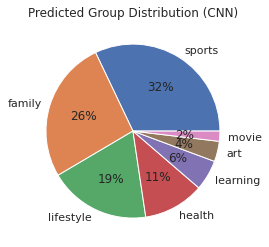

In [52]:
from matplotlib import pyplot

cats = list(set(result_pd['cnn(group)']))
countMap = {}
for i in result_pd['cnn(group)']:
    if i not in countMap:
        countMap[i] = 1
    else:
        countMap[i] += 1
top_cnn = sorted(countMap.items(), key=lambda item: item[1], reverse=True)
#define Seaborn color palette to use
colors = sns.color_palette('deep')
#create pie chart
plt.pie([v for k, v in top_cnn], labels = [k for k, v in top_cnn], colors = colors, autopct='%.0f%%')
plt.title('Predicted Group Distribution (CNN)')
plt.show()

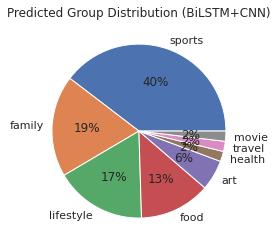

In [55]:
from matplotlib import pyplot

cats = list(set(result_pd['bilstm+cnn(group)']))
countMap = {}
for i in result_pd['bilstm+cnn(group)']:
    if i not in countMap:
        countMap[i] = 1
    else:
        countMap[i] += 1
top_bilstm = sorted(countMap.items(), key=lambda item: item[1], reverse=True)
#define Seaborn color palette to use
colors = sns.color_palette('deep')
#create pie chart
plt.pie([v for k, v in top_bilstm], labels = [k for k, v in top_bilstm], colors = colors, autopct='%.0f%%')
plt.title('Predicted Group Distribution (BiLSTM+CNN)')
plt.show()

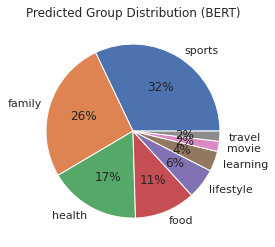

In [54]:
from matplotlib import pyplot

cats = list(set(result_pd['bert(group)']))
countMap = {}
for i in result_pd['bert(group)']:
    if i not in countMap:
        countMap[i] = 1
    else:
        countMap[i] += 1
top_bert = sorted(countMap.items(), key=lambda item: item[1], reverse=True)
#define Seaborn color palette to use
colors = sns.color_palette('deep')
#create pie chart
plt.pie([v for k, v in top_bert], labels = [k for k, v in top_bert], colors = colors, autopct='%.0f%%')
plt.title('Predicted Group Distribution (BERT)')
plt.show()

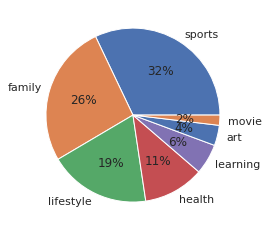

['sports', 'family', 'lifestyle', 'health', 'learning', 'art', 'movie']